# **model_LSTM_7.0** for XRP

Epoch 1/70


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1516 - val_loss: 0.0454 - learning_rate: 0.0100
Epoch 2/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0066 - val_loss: 0.0396 - learning_rate: 0.0100
Epoch 3/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0055 - val_loss: 0.0253 - learning_rate: 0.0100
Epoch 4/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0072 - learning_rate: 0.0100
Epoch 5/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043 - val_loss: 0.0127 - learning_rate: 0.0100
Epoch 6/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0059 - learning_rate: 0.0100
Epoch 7/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - val_loss: 0.0071 - learning_rate: 0.0100
Epoch 8/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 0.0032 - learning_rate: 0.0100
Epoch 9/70
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0037 - learning_rate: 0.0100
Epoch 10/70
127/127 ━

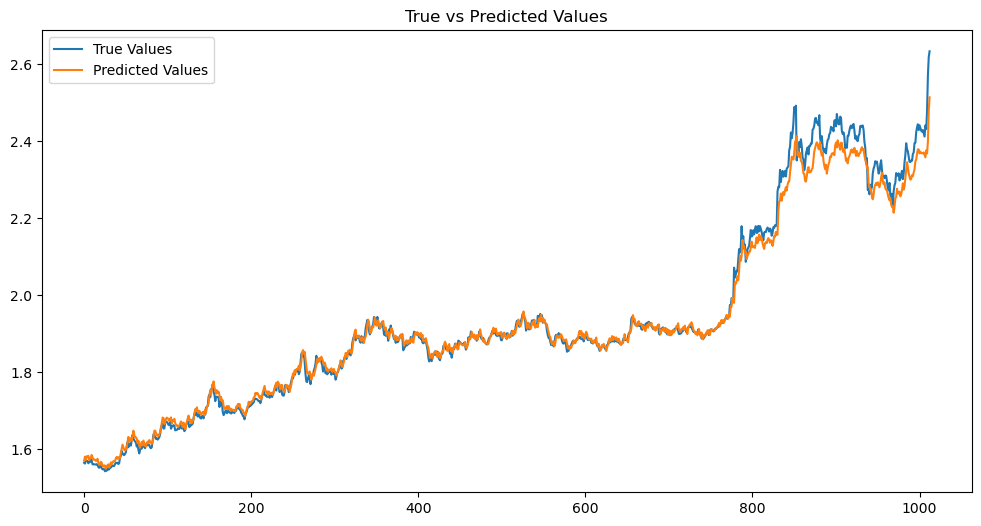

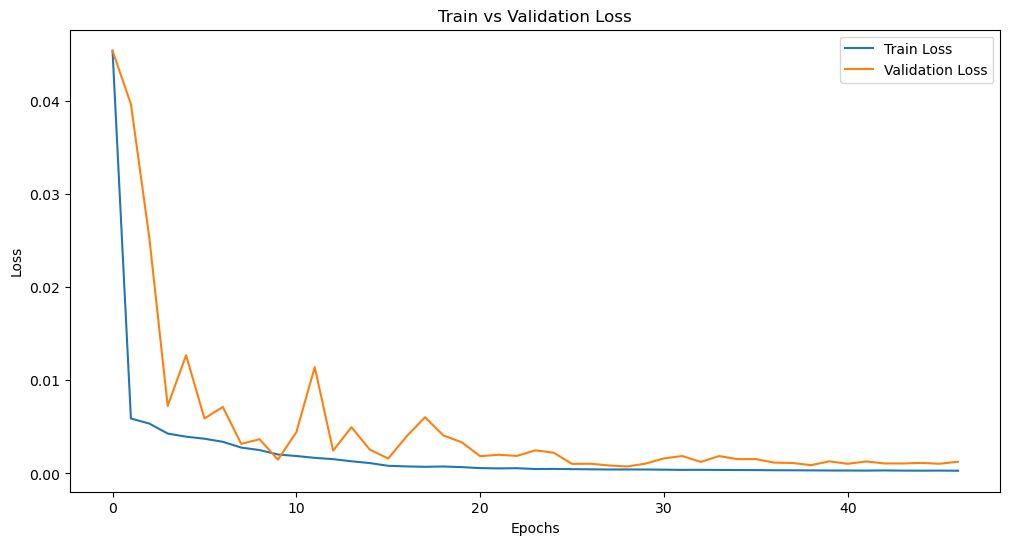

In [320]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('XRP_data_2024_latest_4.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
#joblib.dump(scaler, 'XRP_scaler_LSTM_7.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.4),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
#model.save('XRP_model_LSTM_7.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **model_LSTM_1.0** for BTC

Epoch 1/200


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5823434240.0000 - val_loss: 7099821568.0000 - learning_rate: 0.1000
Epoch 2/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4211972864.0000 - val_loss: 5392304640.0000 - learning_rate: 0.1000
Epoch 3/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2970477824.0000 - val_loss: 4035096832.0000 - learning_rate: 0.1000
Epoch 4/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2030444032.0000 - val_loss: 2978665728.0000 - learning_rate: 0.1000
Epoch 5/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1342645632.0000 - val_loss: 2169843968.0000 - learning_rate: 0.1000
Epoch 6/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 861743744.0000 - val_loss: 1570059136.0000 - learning_rate: 0.1000
Epoch 7/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 541261696.0000 - val_loss: 1134835712.0000 - learning_rate: 0.1000
Epoch 8/200
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 339304576.0000 - val_loss: 828750080.0000 - lear

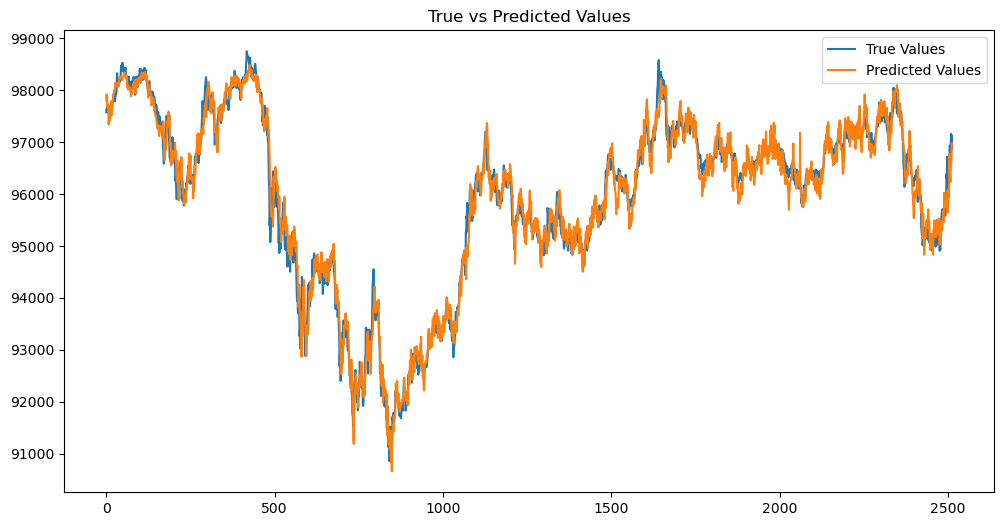

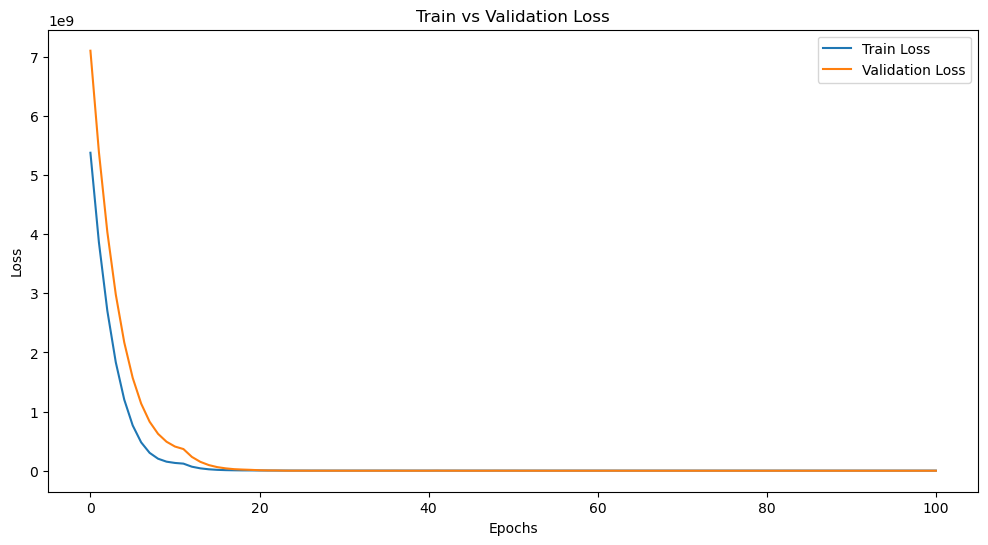

In [357]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('BTC_data_2024_latest_2.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'BTC_scaler_LSTM_1.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.1),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
model.save('BTC_model_LSTM_1.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **model_LSTM_1.0** for SOL

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 19318.7266 - val_loss: 317.4156 - learning_rate: 0.0100
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 285.0643 - val_loss: 11.6684 - learning_rate: 0.0100
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118.9006 - val_loss: 19.6995 - learning_rate: 0.0100
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103.6698 - val_loss: 11.6914 - learning_rate: 0.0100
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95.0504 - val_loss: 5.8046 - learning_rate: 0.0100
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 91.9796 - val_loss: 1.7399 - learning_rate: 0.0100
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 90.7897 - val_loss: 4.1317 - learning_rate: 0.0100
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 89.7052 - val_loss: 1.7632 - learning_rate: 0.0100
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 88.5996 - val_loss: 0.9372 - learning_rate: 

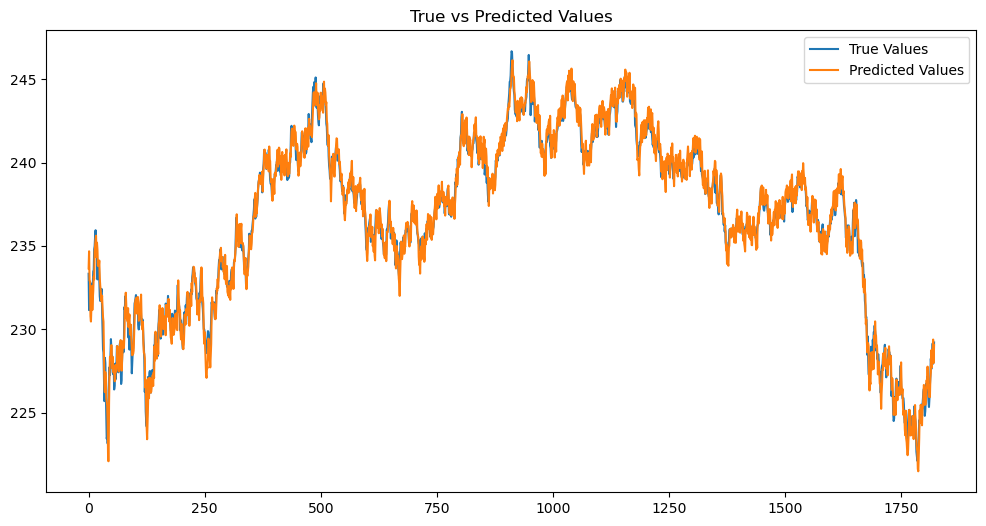

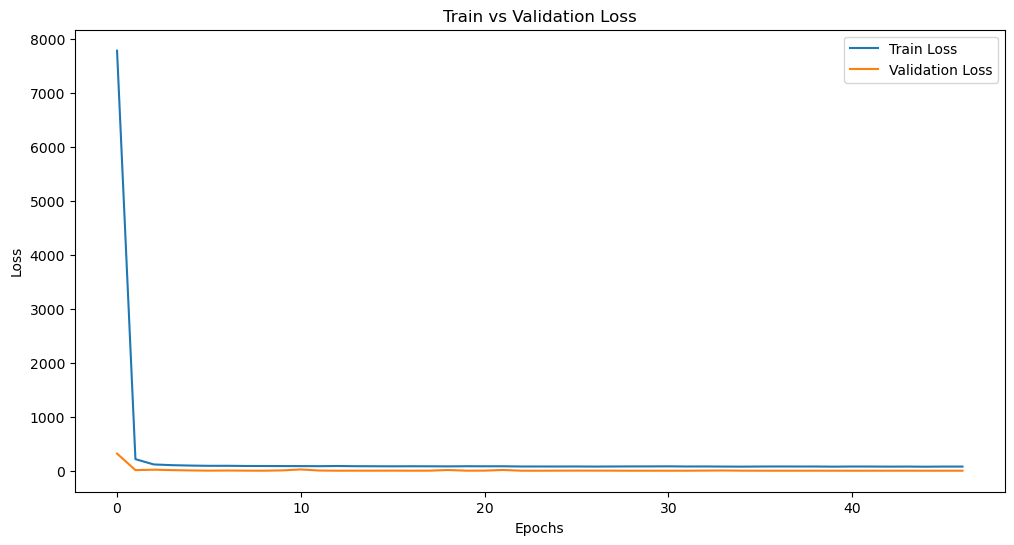

In [345]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('SOL_data_2024_latest_1.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'SOL_scaler_LSTM_1.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.3),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
model.save('SOL_model_LSTM_1.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **model_LSTM_1.0** for ETH

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3557151.0000 - val_loss: 262561.8438 - learning_rate: 0.1000
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 12835.0322 - val_loss: 68288.6562 - learning_rate: 0.1000
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3888.7683 - val_loss: 52700.3281 - learning_rate: 0.1000
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3477.1948 - val_loss: 53386.1406 - learning_rate: 0.1000
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3542.4641 - val_loss: 44015.2109 - learning_rate: 0.1000
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3493.6294 - val_loss: 45479.5625 - learning_rate: 0.1000
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3763.3708 - val_loss: 45401.9883 - learning_rate: 0.1000
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3618.9817 - val_loss: 42072.8594 - learning_rate: 0.1000
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 36

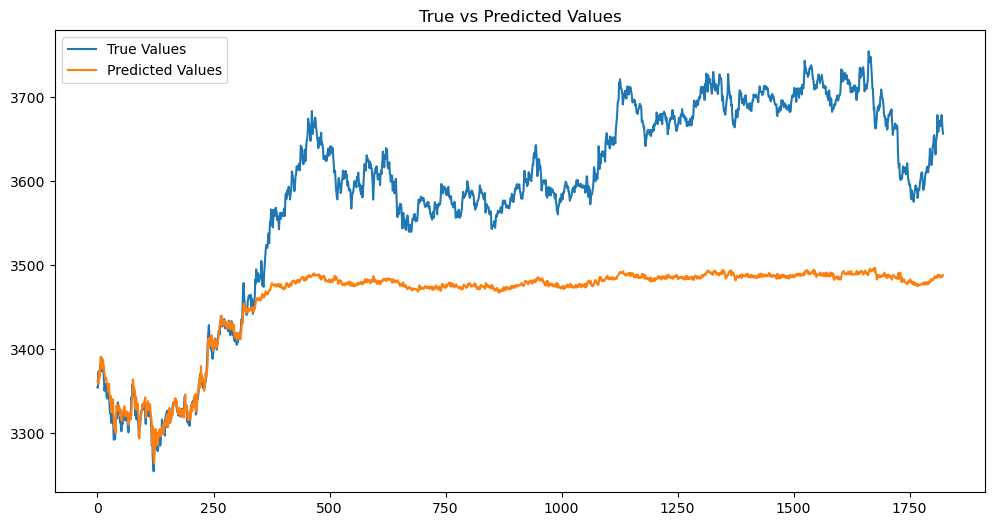

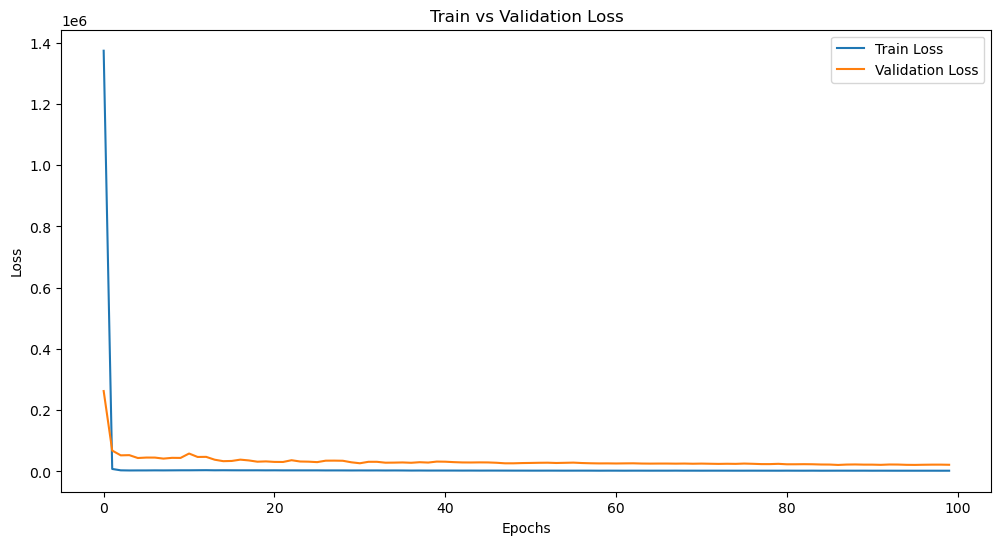

In [363]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('ETH_data_2024_latest_1.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
#joblib.dump(scaler, 'ETH_scaler_LSTM_1.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(512, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.1),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
#model.save('ETH_model_LSTM_1.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **model_LSTM_1.0** for ADA

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0267 - val_loss: 1.8995e-04 - learning_rate: 0.0100
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.2937e-04 - val_loss: 8.3715e-05 - learning_rate: 0.0100
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0039e-04 - val_loss: 1.1376e-04 - learning_rate: 0.0100
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6420e-04 - val_loss: 5.5743e-05 - learning_rate: 0.0100
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.6524e-04 - val_loss: 4.9102e-04 - learning_rate: 0.0100
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.0137e-04 - val_loss: 3.0662e-04 - learning_rate: 0.0100
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.1006e-04 - val_loss: 9.6164e-05 - learning_rate: 0.0100
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5603e-04 - val_loss: 1.4593e-04 - learning_rate: 0.0050
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2

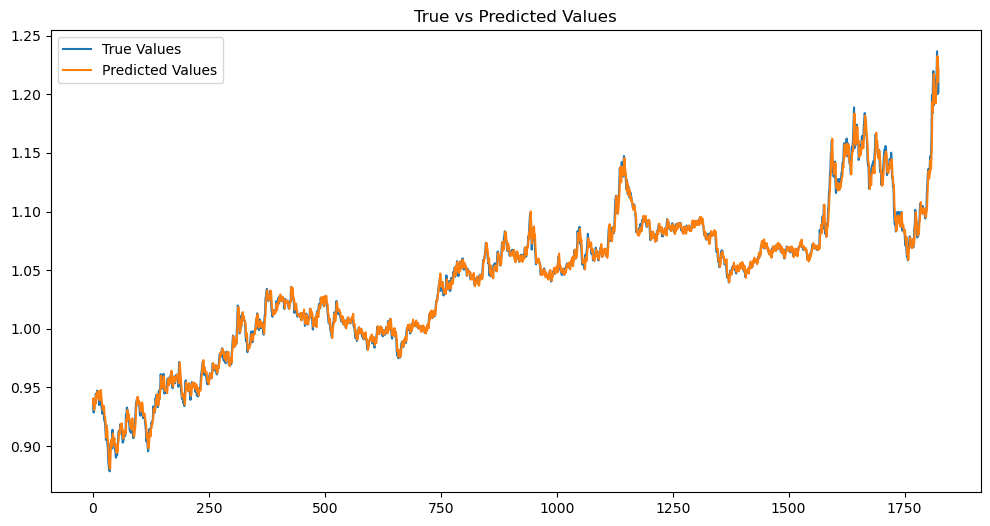

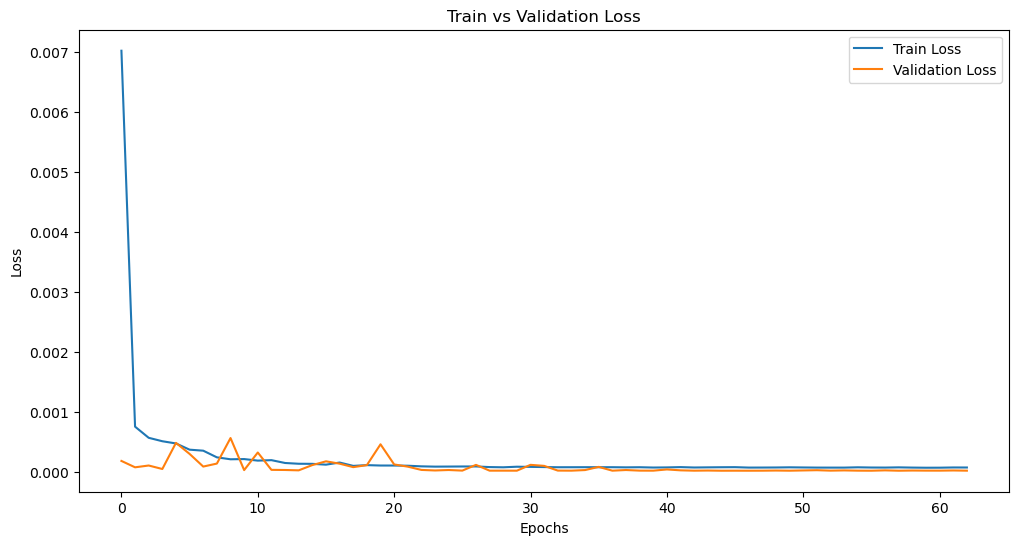

In [367]:
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import joblib
import matplotlib.pyplot as plt

# 난수 설정 함수
def set_seed(seed=7):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# 난수 고정
set_seed(7)

data = pd.read_csv('ADA_data_2024_latest_1.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])

features = data.drop(columns=['timestamp', 'target_close'])
target = data['target_close']

train_size = int(len(data) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
joblib.dump(scaler, 'ADA_scaler_LSTM_1.0.pkl')

# 시계열 데이터 생성 함수 (time_steps=1)
def create_sequences(X, y, time_steps=1):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps + 1):
        X_seq.append(X.iloc[i:i + time_steps].values.flatten())  # 1D로 변환
        y_seq.append(y.iloc[i + time_steps - 1])
    return np.array(X_seq), np.array(y_seq)

# 시계열 데이터 생성
time_steps = 1
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

# LSTM 모델 정의
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(1, X_train_seq.shape[1])),
    Dropout(0.2),
    Dense(1)
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# learning rate 감소
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# 조기 종료 콜백
early_stopping = EarlyStopping(monitor='val_loss', patience=18, restore_best_weights=True)

# 모델 훈련
history = model.fit(
    X_train_seq.reshape(-1, 1, X_train_seq.shape[1]),  # (batch_size, time_steps=1, features)
    y_train_seq,
    validation_data=(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]), y_test_seq),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

# 예측 및 평가
y_pred = model.predict(X_test_seq.reshape(-1, 1, X_test_seq.shape[1]))
r2 = r2_score(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)

print(f"R² Score: {r2}")
print(f"Test MSE: {mse}")

# 모델 저장
model.save('ADA_model_LSTM_1.0.keras')

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.title("True vs Predicted Values")
plt.show()

# 과적합 여부 판단
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()